#### ***Paper Name:*** Feature Selection based Music Selection using Artificial Intelligence (Submitted to CONF-SEML 2023)

***Authors:*** Murari Prasad, Apoorva Bordoloi, Hem Thumar, Manas Saloi, Deepanshu Joshi

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os

import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model, Sequential

In [ ]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
tf.device('/GPU:0')

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
"""  224 x 224 x 3 actual """

data_dir = 'drive/MyDrive/GTZAN/mel_spec_padded_vgg/'

images = []
labels = []
for path,_,files in os.walk(data_dir):
    for name in files:
        temp = cv2.imread(os.path.join(path, name), cv2.IMREAD_UNCHANGED)
        images.append(np.array(cv2.cvtColor(temp, cv2.COLOR_BGRA2BGR)))
        labels.append(name)

In [ ]:
"""  224 x 224 x 3 actual """

data_dir = '/content/gdrive/MyDrive/GTZAN/mel_spec_padded_vgg'

images = []
labels = []
for path,_,files in os.walk(data_dir):
    for name in files:
        temp = cv2.imread(os.path.join(path, name), cv2.IMREAD_UNCHANGED)
        images.append(np.array(cv2.cvtColor(temp, cv2.COLOR_BGRA2BGR)))
        labels.append(name)

classical00000.png


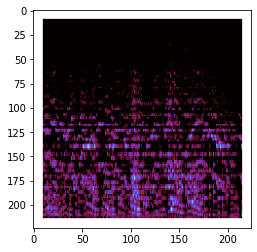

In [ ]:
print(labels[100])
plt.imshow(tf.squeeze(images[100]))

In [ ]:
train_x, test_x, _ , _ = train_test_split(images, [0 for _ in range(1000)], test_size=0.1, shuffle=True, random_state=42)

In [ ]:
train_x = np.array(train_x)
test_x = np.array(test_x)

train_x = train_x / 255.0
test_x = test_x / 255.0

In [ ]:
X_tensor = tf.convert_to_tensor(train_x)
test_tensor = tf.convert_to_tensor(test_x)

In [ ]:
X_tensor.shape

TensorShape([900, 224, 224, 3])

In [ ]:
test_tensor.shape

TensorShape([100, 224, 224, 3])

#### Model Building

In [ ]:
from keras.applications.vgg19 import VGG19

In [ ]:
vgg = VGG19()
vgg.summary()

574710816/574710816 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# from keras.utils.vis_utils import plot_model
# plot_model(vgg, to_file='vgg_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
encoder = Sequential()

In [ ]:
# Copying the layers into a sequential model for encoder
for i, lay in enumerate(vgg.layers):
  if i<22:
    encoder.add(lay)

In [ ]:
# locking early layers(till block 4(inc))
for i, lay in enumerate(encoder.layers):
  if i<16:
    lay.trainable=False
  else:
    lay.trainable=True

In [ ]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
# plot_model(encoder, to_file='encoder_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# !pip install visualkeras
# import visualkeras

In [ ]:
# visualkeras.layered_view(encoder,legend=True, draw_volume=True)

In [ ]:
# Decoder model

decoder = Sequential([
    layers.Conv2D(256, kernel_size=3, activation='relu', padding='same', input_shape=(7,7,512)),
    layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),
    layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),
    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),
    layers.Conv2D(16, kernel_size=3, activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),
    layers.Conv2D(3, kernel_size=3, activation='sigmoid', padding='same'),
    layers.UpSampling2D((2,2)),
])

In [ ]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)       

In [ ]:
# plot_model(decoder, to_file='vgg_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# from collections import defaultdict

# color_map = defaultdict(dict) 
# color_map[layers.UpSampling2D]['fill'] = 'blue'

In [ ]:
# visualkeras.layered_view(decoder,legend=True, draw_volume=True, color_map=color_map)

In [ ]:
# Defining AE as encoder + decoder
autoenc = Sequential([encoder, decoder])

#### Training

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, use_ema=True)

In [ ]:
autoenc.compile(optimizer=optimizer, loss=losses.MeanSquaredError(), metrics=['mae'])

In [ ]:
history = autoenc.fit(X_tensor, X_tensor,
                epochs=500,
                shuffle=True,
                batch_size=32)

Epoch 1/500
29/29 [==============================] - 22s 243ms/step - loss: 0.0640 - mae: 0.1697
Epoch 2/500
29/29 [==============================] - 6s 220ms/step - loss: 0.0238 - mae: 0.0906
Epoch 3/500
29/29 [==============================] - 6s 208ms/step - loss: 0.0217 - mae: 0.0854
Epoch 4/500
29/29 [==============================] - 6s 219ms/step - loss: 0.0213 - mae: 0.0843
Epoch 5/500
29/29 [==============================] - 6s 206ms/step - loss: 0.0207 - mae: 0.0828
Epoch 6/500
29/29 [==============================] - 7s 225ms/step - loss: 0.0204 - mae: 0.0820
Epoch 7/500
29/29 [==============================] - 6s 210ms/step - loss: 0.0202 - mae: 0.0815
Epoch 8/500
29/29 [==============================] - 6s 223ms/step - loss: 0.0201 - mae: 0.0811
Epoch 9/500
29/29 [==============================] - 6s 208ms/step - loss: 0.0204 - mae: 0.0819
Epoch 10/500
29/29 [==============================] - 6s 221ms/step - loss: 0.0199 - mae: 0.0806
Epoch 11/500
29/29 [==================

In [ ]:
np.save('AE_history.npy',history.history)

In [ ]:
history=np.load('AE_history.npy',allow_pickle='TRUE').item()

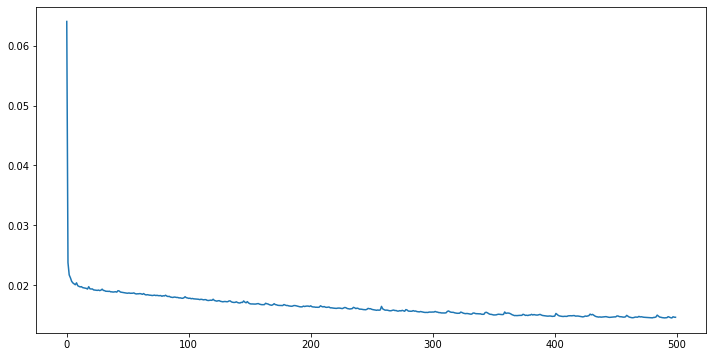

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history['loss'])
plt.show()

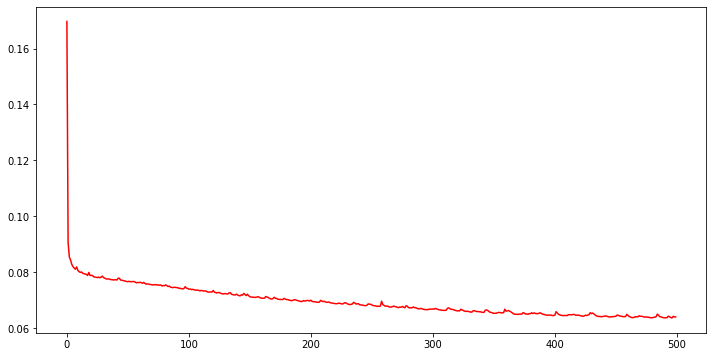

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history['mae'], color='red')
plt.show()

In [ ]:
# encoder.compile(optimizer=optimizer, loss=losses.BinaryCrossentropy())
# decoder.compile(optimizer=optimizer, loss=losses.BinaryCrossentropy())
encoder.save("drive/MyDrive/GTZAN/vgg_enc_final_h5", save_format='h5')
decoder.save("drive/MyDrive/GTZAN/vgg_dec_final_h5", save_format='h5')

In [ ]:
autoenc.evaluate(x=test_tensor, y=test_tensor)

4/4 [==============================] - 1s 141ms/step - loss: 0.0216 - mae: 0.0812


[0.021570170298218727, 0.08122038841247559]